In [292]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
    
from sklearn.metrics import calinski_harabasz_score, silhouette_score, davies_bouldin_score, make_scorer
from sklearn.cluster import DBSCAN, AgglomerativeClustering, Birch, OPTICS, MeanShift
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [6]:
df = pd.read_csv("comments.csv")

In [7]:
# Show head of dataset 
df.head()

,id,emo
0,468483253,[0.3 0.05 0.04 0.94 0.04 0.07 0.2 0.05]
1,230927305,[0.14 0.09 0.03 0.05 0.03 0.04 0.87 0.18]
2,35737691,[0.38 0.2 0.11 0.32 0.04 0.09 0.35 0.09]
3,93940744,[0.92 0.04 0.04 0.06 0.02 0.02 0.08 0.1 ]
4,488047952,[0.38 0.2 0.11 0.32 0.04 0.09 0.35 0.09]


In [8]:
# Get a size of dataset
len(df)

2761977

In [9]:
# Discover types of data
df.dtypes

id      int64
emo    object
dtype: object

In [10]:
# Discover type of emo column for further transformations
type(df['emo'][0])

str

In [11]:
df['emo'][0]

'[0.3  0.05 0.04 0.94 0.04 0.07 0.2  0.05]'

In [12]:
# Discover if null values in dataset -> no null values
df.isnull().sum()

id     0
emo    0
dtype: int64

In [13]:
# Negative values for id column is quite strange because of a definition of "id". 
# Maybe these id are large numbers, therefore, it was written into memory as negative
df.describe()

,id
count,2.761977e+06
mean,2.156865e+08
std,1.662448e+08
min,-1.930596e+08
25%,5.990703e+07
50%,1.842757e+08
75%,3.538382e+08
max,6.119504e+08


In [14]:
# How many negative values for id
sum(df.id < 0)

3109

In [15]:
# Calculate number of users
len(df.groupby('id').nunique())

169066

In [16]:
# Show data for negative values
df.loc[df.id < 0]

,id,emo
4603,-94833853,[0.08 0.86 0.28 0.5 0.05 0.04 0.06 0.02]
4636,-131954297,[0.87 0.21 0.11 0.05 0.02 0.02 0.05 0.65]
5474,-88772190,[0.16 0.04 0.03 0.91 0.02 0.19 0.1 0.05]
6270,-88772190,[0.13 0.47 0.04 0.51 0.03 0.02 0.25 0.02]
6970,-80040324,[0.44 0.07 0.03 0.34 0.03 0.06 0.09 0.04]
...,...,...
2743840,-80040324,[0.26 0.09 0.04 0.16 0.02 0.12 0.16 0.03]
2753826,-80040324,[0.25 0.04 0.13 0.09 0.02 0.16 0.1 0.05]
2753919,-80040324,[0.16 0.14 0.05 0.2 0.02 0.78 0.35 0.03]
2759904,-80040324,[0.27 0.79 0.07 0.68 0.03 0.28 0.27 0.02]


In [17]:
# Отрицательные - значения, которые не поместились в память и возможно какаим-то образом стали отрицательными

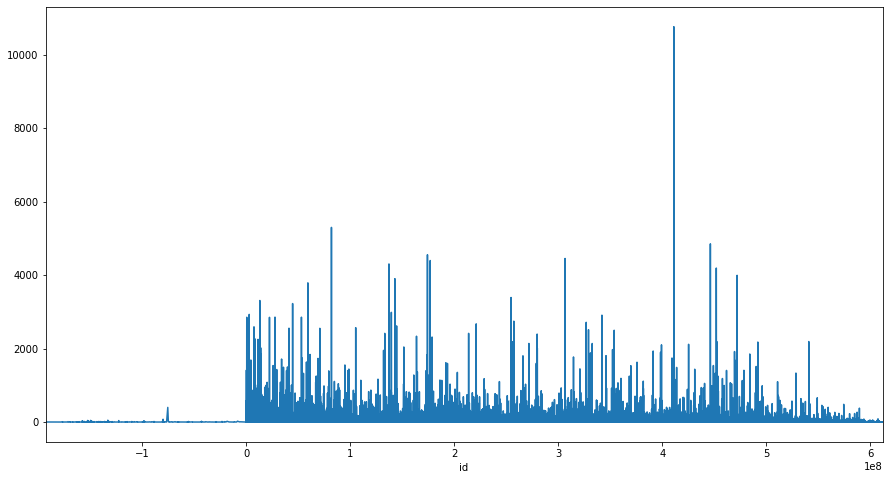

In [19]:
# Show a distribution of the number of user's comments
plt.figure(figsize=(15,8))
df.groupby('id')['emo'].nunique().plot()

We see a peak and we consider it an outlier and remove it from our sample.

Also remove users with negative id, because of the little number of comments.

And remove all users with at most 10 comments.

In [20]:
# Detect user id for the outlier
grouped_series = df.groupby('id')['emo'].nunique()
grouped_series.idxmax()

411185656

In [68]:
grouped_df = grouped_series.to_frame()
grouped_df = grouped_df.loc[grouped_df.emo <= 10]
ids_to_ignore = list(grouped_df['emo'].index)

In [100]:
df_to_drop = df.loc[(df.id == 411185656) | (df.id < 0) | (df.id.isin(ids_to_ignore))]
df = pd.concat([df, df_to_drop, df_to_drop]).drop_duplicates(keep=False)

In [101]:
df

,id,emo
0,468483253,[0.3 0.05 0.04 0.94 0.04 0.07 0.2 0.05]
1,230927305,[0.14 0.09 0.03 0.05 0.03 0.04 0.87 0.18]
3,93940744,[0.92 0.04 0.04 0.06 0.02 0.02 0.08 0.1 ]
5,488047952,[0.58 0.05 0.03 0.75 0.02 0.08 0.6 0.05]
6,4953068,[0.17 0.4 0.17 0.36 0.08 0.06 0.05 0.03]
...,...,...
2761970,247033903,[0.83 0.03 0.94 0.34 0.02 0.09 0.39 0.88]
2761971,71690605,[0.15 0.69 0.06 0.18 0.03 0.02 0.07 0.34]
2761972,38702672,[0.83 0.08 0.03 0.09 0.03 0.03 0.94 0.03]
2761973,71535611,[0.16 0.11 0.04 0.31 0.73 0.05 0.32 0.03]


#### The final plot shows distribution of comments number for every user

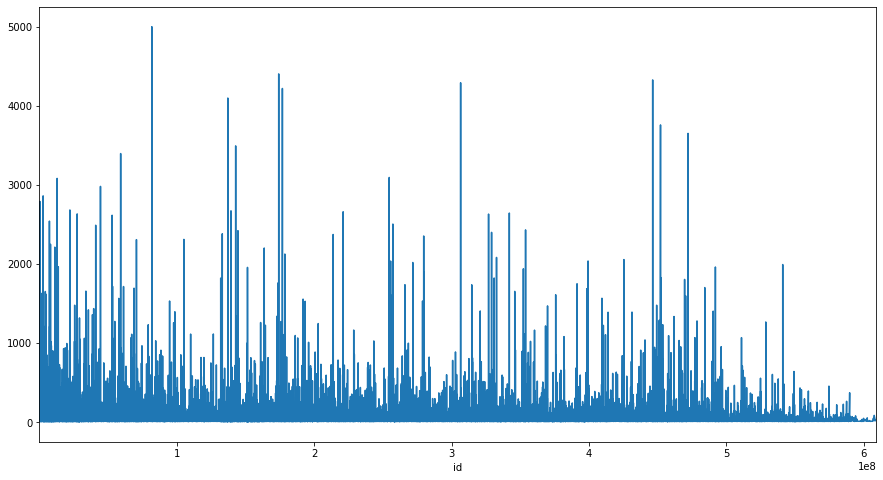

In [102]:
plt.figure(figsize=(15,8))
df.groupby('id')['emo'].nunique().plot()

## Getting average emo vectors for every user

In [89]:
def vector_str_to_list(vector_str):
    return [float(num) for num in vector_str[1:-1].split(" ") if num]

In [103]:
def get_average_vector_for_df(df):
    ids = df.id.unique()

    users = []
    vectors = []
    
    for user_id in ids:
        sample = df.loc[df.id == user_id]
        emo_vectors = [vector_str_to_list(vector) for vector in list(sample["emo"])]
        average_vector = np.average(emo_vectors, axis=0)
        users.append(user_id)
        vectors.append(average_vector)
        
    return pd.DataFrame(data={"id": users, "emo": vectors})

In [104]:
df_average = get_average_vector_for_df(df)

In [105]:
df_average

,id,emo
0,468483253,"[0.31202247191011245, 0.2795505617977528, 0.13..."
1,230927305,"[0.3445714285714286, 0.3072857142857144, 0.108..."
2,93940744,"[0.37546762589928034, 0.2676978417266186, 0.15..."
3,488047952,"[0.36630952380952386, 0.28880952380952385, 0.2..."
4,4953068,"[0.275284671532847, 0.24433576642335797, 0.120..."
...,...,...
30870,262138689,"[0.4111538461538462, 0.20423076923076922, 0.15..."
30871,143313379,"[0.164, 0.532, 0.11800000000000002, 0.45333333..."
30872,5631313,"[0.24307692307692313, 0.2515384615384616, 0.42..."
30873,247033903,"[0.4628571428571429, 0.29285714285714287, 0.21..."


## Clustering the users

In [199]:
X = np.array(list(df_average['emo']))
X = StandardScaler().fit_transform(X)

In [200]:
X

array([[-0.66175474,  0.23925263, -0.36051987, ...,  0.35958038,
         0.01378558, -0.34132472],
       [-0.36825455,  0.62472675, -0.81422917, ..., -0.12932297,
         1.04519873,  0.43600532],
       [-0.0896576 ,  0.07451884,  0.03198681, ...,  0.58285866,
         0.84149509,  0.09545072],
       ...,
       [-1.28345   , -0.15007062,  4.47817368, ..., -0.40523778,
        -1.63679902, -1.94574785],
       [ 0.69835045,  0.42419276,  1.03101473, ..., -1.30258763,
         1.31007063,  1.46060716],
       [-1.07346923, -0.95481689,  0.50995813, ...,  1.97652327,
        -1.19337012,  0.28640114]])

### Agglomerative Hierarchical Clustering

According to the assumtion that number of main clusters should be <b>8</b>, we specify it by <b>n_clusters</b> parameter.

In [160]:
clustering_ah = AgglomerativeClustering(n_clusters=8).fit(X)

In [162]:
labels = clustering_ah.labels_

In [193]:
labels

array([1, 2, 2, ..., 6, 0, 6])

#### Show some results for Agglomerative Hierarchical Clustering and see how close parts of vectors for one cluster. Users for each cluster were chosen randomly.

#### We can't visualize the clusters data because the vectors are 8-dimension vectors, but according to the meaning of the Plutchick's system these vectors can be presented by radar diagram.

In [165]:
# 1 cluster
df_average['emo'][886]

array([0.295     , 0.10777778, 0.10777778, 0.41277778, 0.05833333,
       0.29222222, 0.34      , 0.11333333])

In [166]:
# 1 cluster
df_average['emo'][5581]

array([0.28708333, 0.2775    , 0.10875   , 0.3725    , 0.07541667,
       0.2375    , 0.29458333, 0.11416667])

<img src="pic/1_cluster.png" width="800" />
(The chart was created by Excel tools)

In [170]:
# 7 cluster
df_average['emo'][9005]

array([0.415   , 0.29125 , 0.110625, 0.30875 , 0.049375, 0.138125,
       0.223125, 0.211875])

In [171]:
# 7 cluster
df_average['emo'][8]

array([0.44372525, 0.26779844, 0.17590282, 0.30137772, 0.06825635,
       0.15739252, 0.31144971, 0.15588282])

<img src="pic/7_cluster.png" width="800" />
(The chart was created by Excel tools)

In [178]:
# 6 cluster
df_average['emo'][49]

array([0.20987013, 0.27896104, 0.09532468, 0.47948052, 0.05324675,
       0.2825974 , 0.30194805, 0.09896104])

In [179]:
# 6 cluster
df_average['emo'][290]

array([0.23166667, 0.28055556, 0.175     , 0.555     , 0.06055556,
       0.29722222, 0.36166667, 0.22944444])

<img src="pic/6_cluster.png" width="800" />
(The chart was created by Excel tools)

We can see that the figures for the users from the same clusters are similiar.

### Birch algorithm

According to the assumtion that number of main clusters should be <b>8</b>, we specify it by <b>n_clusters</b> parameter as we did for agglomerative hierarchical clustering.

In [196]:
clustering_brch = Birch(n_clusters=8, threshold=0.1)
clustering_brch.fit(X)
clustering_brch.predict(X)

array([1, 6, 1, ..., 0, 6, 0])

### Mean Shift

In [295]:
# Try to change bandwidth because this parameter does the greatest impact to the result
# bandwidth=2
clustering_mean_shift = MeanShift(bandwidth=2).fit(X)

In [307]:
labels = clustering_mean_shift.labels_

In [308]:
# Too many clusters
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_clusters_

172

In [304]:
# bandwidth=4
clustering_mean_shift = MeanShift(bandwidth=4).fit(X)

In [311]:
labels = clustering_mean_shift.labels_

In [312]:
# Too few clusters
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_clusters_

3

In [315]:
# bandwidth = 3.5
clustering_mean_shift = MeanShift(bandwidth=3.5).fit(X)

In [316]:
labels = clustering_mean_shift.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_clusters_

4

### Grid search and metrics

Metrics, which will be used for our unsupervised learning example are: 
- Silhouette index
<img src="pic/si.png" width="800" />

- Davies-Bouldin
<img src="pic/db.png" width="800" />

- Calinski-Harabasz
<img src="pic/ch.png" width="800" />

In [275]:
# Grid parameters for Birch algorithm
param_grid_birch = {"threshold": [0.1, 0.3, 0.5],
                    "branching_factor": [20, 30, 50],
                    "n_clusters": [7,8,9]
                    }

In [ ]:
# Grid parameters for Agglomerative hierarchical method
param_grid_ah = {"distance_threshold": [0.1, 0.3, 0.5],
                 "affinity": ["euclidean", "l1", "l2"],
                 "n_clusters": [7,8,9]
                }

In [ ]:
# Grid parameters for OPTICS
param_grid_optics = {"bandwidth":[3,3.5, 4],
                     "max_iter": [200, 250, 300],
                     "min_bin_freq": [1,2,3]
                    }

#### Custom scorer functions for chosen metrics for unsupervised learning problem

In [289]:
def cv_silhouette_scorer(estimator, X):
    estimator.fit(X)
    cluster_labels = estimator.labels_
    num_labels = len(set(cluster_labels))
    num_samples = len(X.index)
    if num_labels == 1 or num_labels == num_samples:
        return -1
    else:
        return silhouette_score(X, cluster_labels)

In [ ]:
def cv_davies_bouldin_scorer(estimator, X):
    estimator.fit(X)
    cluster_labels = estimator.labels_
    num_labels = len(set(cluster_labels))
    num_samples = len(X.index)
    if num_labels == 1 or num_labels == num_samples:
        return -1
    else:
        return davies_bouldin_score(X, cluster_labels)

In [ ]:
def cv_calinski_harabasz_scorer(estimator, X):
    estimator.fit(X)
    cluster_labels = estimator.labels_
    num_labels = len(set(cluster_labels))
    num_samples = len(X.index)
    if num_labels == 1 or num_labels == num_samples:
        return -1
    else:
        return calinski_harabasz_score(X, cluster_labels)

### Grid search part

In [ ]:
for estimator, params in zip([clustering_brch, clustering_ah, ], [param_grid_birch, param_grid_ah]):
    cv = [(slice(None), slice(None))]
    
    # Define Grid Search for the Silhouette scorer
    rid_silhouette = GridSearchCV(estimator=estimator,
                        param_grid=params, 
                        scoring=cv_silhouette_scorer, 
                        cv=cv)
    
    grid_silhouette.fit(X)
    # Table for grid results
    cs_results_silhouette = grid_silhouette.cv_results_
    # Best estimator
    best_estimator_silhouette = grid_silhouette.best_estimator_
    
    # Define Grid Search for the Davies Bouldin scorer
    grid_davies_bouldin = GridSearchCV(estimator=estimator,
                        param_grid=params, 
                        scoring=cv_davies_bouldin_scorer, 
                        cv=cv)
    
    grid_davies_bouldin.fit(X)
    # Table for grid results
    cs_results_davies_bouldin = grid_davies_bouldin.cv_results_
    # Best estimator
    best_estimator_davies_bouldin = grid_davies_bouldin.best_estimator_
    
    # Table for grid results
    grid_silhouette.cv_results_
    
    # Define Grid Search for the Calinski Harabasz scorer
    grid_calinski_harabasz = GridSearchCV(estimator=estimator,
                        param_grid=params, 
                        scoring=cv_calinski_harabasz_scorer, 
                        cv=cv)
    
    grid_calinski_harabasz.fit(X)
    # Table for grid results
    cs_results_calinski_harabasz = grid_calinski_harabasz.cv_results_
    # Best estimator
    best_estimator_calinski_harabasz = grid_calinski_harabasz.best_estimator_

### Visualization of grid search scores

In [ ]:
def plot_grid_search():
    scores = [entry.mean_validation_score for entry in grid.grid_scores_]
    # the shape is according to the alphabetical order of the parameters in the grid
    scores = np.array(scores).reshape(len(C_range), len(gamma_range))
    for c_scores in scores:
        plt.plot(gamma_range, c_scores, '-')

In [ ]:
plot_grid_search()